<a href="https://colab.research.google.com/github/sejin-coding/infinite-challenge/blob/main/%EC%A1%B8%ED%94%84_%EC%A7%80%ED%8F%90_%ED%99%98%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip uninstall tensorflow
!pip install absl-py aiohttp astor attrs backcall brotlipy cachetools certifi cffi charset-normalizer click cryptography cycler decorator fonttools gast google-auth google-auth-oauthlib grpcio h5py idna importlib-metadata ipykernel ipython joblib keras-preprocessing matplotlib pandas patsy pexpect pillow protobuf psutil ptyprocess pyasn1 pyasn1-modules pycparser pygments pyjwt pyopenssl pyparsing pysocks python-dateutil pytz requests requests-oauthlib rsa scikit-learn scipy seaborn setuptools six tensorboard tensorflow tensorflow-estimator termcolor threadpoolctl tornado traitlets typing-extensions werkzeug wrapt
!pip install tensorflow==2.8.0
!pip install pyarrow==7.0.0
!apt-get install -y libblas-dev liblapack-dev libpng-dev libjpeg-dev zlib1g-dev libtiff-dev libopenblas-dev libcurl4-openssl-dev libssl-dev
!pip install --upgrade tensorflow keras
!apt-get install tesseract-ocr
!pip install pytesseract

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0


##1. 이미지 업로드

In [21]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

# 파일 확인
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving sweden.png to sweden.png
Uploaded file: sweden.png


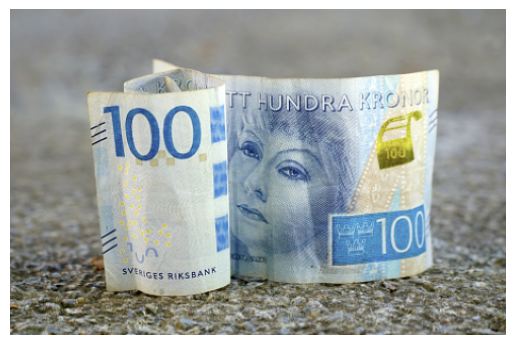

In [22]:
import cv2
from matplotlib import pyplot as plt

# 업로드한 파일 경로 설정
image_path = 'sweden.png'

# OpenCV로 이미지 읽기
img = cv2.imread(image_path)

# 이미지를 시각화
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


##2. 지폐 탐지 모델 불러오기

In [13]:
!git clone https://github.com/microsoft/banknote-net.git

Cloning into 'banknote-net'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 123 (delta 13), reused 25 (delta 10), pack-reused 94 (from 1)
Receiving objects: 100% (123/123), 54.51 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [14]:
%cd banknote-net

/content/banknote-net/banknote-net


In [15]:
!ls ./data/example_images/SEK/val/

100_1  100_2  200_1  200_2  20_1  20_2	50_1  50_2


In [16]:
!ls ./src/trained_models/custom_classifier.h5

./src/trained_models/custom_classifier.h5


In [25]:
from tensorflow.keras.models import load_model

# Load the pre-trained custom classifier model
model = load_model('./src/trained_models/custom_classifier.h5')


In [17]:
!python src/predict_custom.py --bsize 1 --data_path ./data/example_images/SEK/val/ --model_path ./src/trained_models/custom_classifier.h5


2024-10-11 15:57:37.955554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-11 15:57:37.955593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Found 15 images belonging to 8 classes.
2024-10-11 15:57:41.534316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-11 15:57:41.534368: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-11 15:57:41.534410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel drive

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test_datagen object
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Now you can use it to create the validation generator
validation_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),  # Assuming 224x224 image size
    batch_size=1,
    shuffle=False,
    class_mode="categorical",
)

# Print the class indices to understand the mappings
print(validation_generator.class_indices)


Found 15 images belonging to 8 classes.
{'100_1': 0, '100_2': 1, '200_1': 2, '200_2': 3, '20_1': 4, '20_2': 5, '50_1': 6, '50_2': 7}


##3. 이미지 전처리

In [45]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load the image and resize it to 224x224
img = load_img('sweden.png', target_size=(224,224))

img_array = img_to_array(img)

# Expand dimensions to match the input shape for the model
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image data (as your model expects images rescaled)
img_array = img_array / 255.0

# Ensure the shape is (1, 224, 224, 3)
print(img_array.shape)  # It should output (1, 224, 224, 3)


(1, 224, 224, 3)


##4. 모델 예측 실행 및 클래스 도출

In [47]:
# Now make the prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted class: {predicted_class}")

Predicted class: 0


In [48]:
class_labels = {
    0: 'Sweden 100 front',
    1: 'Sweden 100 back',
    2: 'Sweden 200 front',
    3: 'Sweden 200 back',
    4: 'Sweden 20 front',
    5: 'Sweden 20 back',
    6: 'Sweden 50 front',
    7: 'Sweden 50 back'
}

# Print the predicted label
predicted_label = class_labels.get(predicted_class, "Unknown class")
print(f"Predicted label: {predicted_label}")


Predicted label: Sweden 100 front


##5. 실시간 환율 불러오기

In [49]:
import requests

# API endpoint for exchange rates (using RatesDB for example)
api_url = "https://free.ratesdb.com/v1/rates?from=SEK&to=KRW"
response = requests.get(api_url)
data = response.json()

# Get the exchange rate from SEK to KRW
sek_to_krw_rate = data['data']['rates']['KRW']
print(f"Current SEK to KRW exchange rate: {sek_to_krw_rate}")


Current SEK to KRW exchange rate: 130.1427


##6. 실시간 환율을 반영한 원화 환산






In [50]:
# 0 -> 100 SEK (front)
# 1 -> 100 SEK (back)
# 2 -> 200 SEK (front)
# 3 -> 200 SEK (back)
# 4 -> 20 SEK (front)
# 5 -> 20 SEK (back)
# 6 -> 50 SEK (front)
# 7 -> 50 SEK (back)

if predicted_class == 0 or predicted_class == 1:
    sek_amount = 100
elif predicted_class == 2 or predicted_class == 3:
    sek_amount = 200
elif predicted_class == 4 or predicted_class == 5:
    sek_amount = 20
elif predicted_class == 6 or predicted_class == 7:
    sek_amount = 50
else:
    sek_amount = 0
    print("Unknown class predicted!")

# Convert SEK amount to KRW and round down to nearest integer
if sek_amount > 0:
    krw_amount = int(sek_amount * sek_to_krw_rate)
    print(f"{sek_amount} SEK is equal to {krw_amount} KRW.")

100 SEK is equal to 13014 KRW.


##7. 최종 결과 도출

In [43]:
from IPython.display import display, HTML

# HTML to display bold and large text
display(HTML(f"""
    <h2><b>스웨덴 {sek_amount}크로나</b></h2>
    <h3>실시간 환율 정보: {sek_to_krw_rate}</h3>
    <h3><b>원화: {krw_amount}원 입니다.</b></h3>
"""))